# Visualisation of data in Zarr format

First, we'll load some libraries

In [92]:
import numpy as np
from microfilm import microanim

from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

from bia_explorer.utils import scale_to_uint8
from bia_explorer.io import load_full_bia_study

## Loading the data from the BioImage Archive

Next we'll load a study and choose a specific image:

In [90]:
study = load_full_bia_study("S-BIAD564")

image = study.images["IM83"]

print(study.description)

Image files (raw and processed) underlying the study 'A role for the centrosome in regulating the rate of neuronal efferocytosis by microglia in vivo' by Moller et. al; eLife 2022. The aim of the study was to investigate neuronal efferocytosis, a process where microglia phagocytose apoptotic neurons in the developing brain. By taking a live imaging approach in the transparent zebrafish embryonic brain, they show a central role for microtubules and the centrosome in neuronal efferocytosis. The study finds that while microglia generate multiple microtubule-based branches, they only successfully engulf one apoptotic neuron at a time, and that centrosomal migration into microglial branches is the rate-limiting step in this process. The PLC-DAG signaling pathway is identified as an important mechanism in centrosomal recruitment to the phagocytic cup. Finally, photoswitchable perturbations of microtubules show how microglia are increadibly robust and can switch modes of phagocytosis when lac

Next we can load the image data from a Zarr store:

In [4]:
store = parse_url(image.representations[1].uri, mode="r").store

reader = Reader(parse_url(image.representations[1].uri))
# nodes may include images, labels etc
nodes = list(reader())
# first node will be the image pixel data
image_node = nodes[0]

## Selecting a resolution, region of interest and channel

The data are pyramidal, so we'll pick the highest resolution:

In [5]:
highest_res = image_node.data[0]

This is a lazily loaded Dask array:

In [6]:
highest_res

dask.array<from-zarr, shape=(60, 3, 41, 1024, 1024), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

We'll select a single channel and a particular region of interest, and get a numpy array:

In [76]:
voldata = highest_res[:,2,:,400:800,300:].compute()

We need to make sure that dimensions are T, C, Z, X, Y. Since we have a single channel, we need to insert an extra dimension:

In [93]:
expanded_vol = np.expand_dims(voldata, axis=0)

## Deriving physical units from metadata

Now we can also get some metadata from the image that we'll need in order to label the figure, set the scale bar and time point:

In [78]:
time_resolution = int(image.attributes['Timeresolution[sec]'])
channel_label = image.attributes['Channel_3']
pixel_size_nm = int(image.attributes['Pixel_size[nm]'])

## Constructing an animation

Now we can construct an animation from the volume, using a maximum intensity projection at each time point:

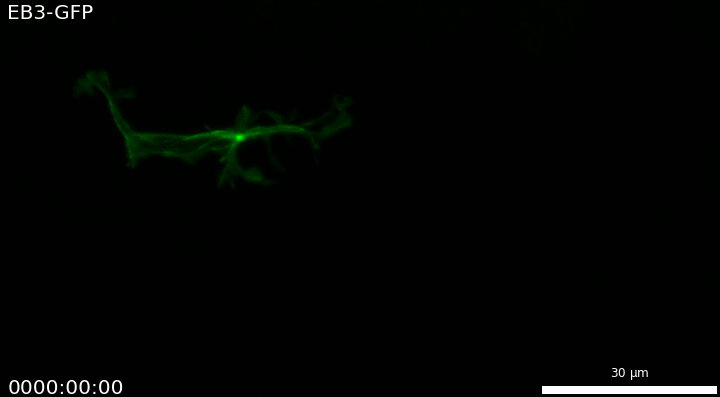

In [99]:
anim = microanim.Microanim(
    data=expanded_vol, volume_proj='max', cmaps=['pure_green'], fig_scaling=10,
    unit='um', scalebar_size_in_units=30, scalebar_unit_per_pix=pixel_size_nm/1000,
    scalebar_thickness=0.02
)
anim.add_label(channel_label, label_font_size=20)
anim.add_time_stamp('T', time_resolution, location='lower left', timestamp_size=20);

## Saving and visualisating

We can save the movie, then reload it to view on loop:

In [94]:
output_fpath = "../movie.gif"
anim.save_movie(output_fpath, fps=10)

In [95]:
from IPython.display import Image as ipyImage

with open(output_fpath, "rb") as fh:
    im = ipyImage(data=fh.read())

and finally:

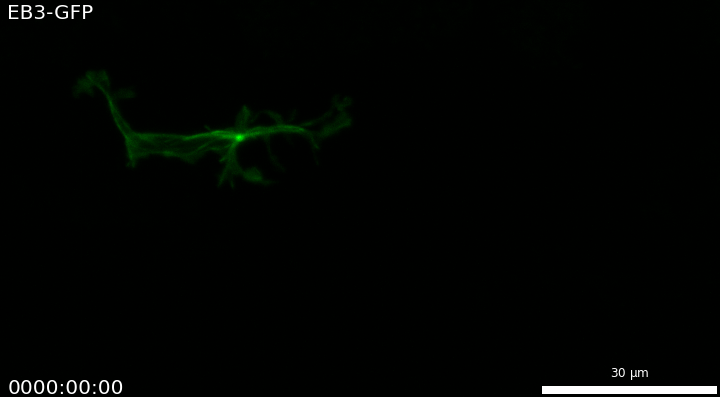

In [88]:
im